# Directory shenanigans

In [1]:
import os
import sys

# 1. repo_dir used later
repo_dir = os.path.abspath(os.path.join(os.path.abspath(""), ".."))

# 2. sys.path must be appended for importing modules
sys.path.append(repo_dir)

# 3. fix current working directory
os.chdir(os.path.abspath(os.path.join(os.path.abspath(""))))

# Import libaries + assign device (CPU/GPU)

In [2]:
from models.cm_hybrid import ContinuousMixture
from models.lo_hybrid import bins_lo, fast_bins_lo
from torch.utils.data import DataLoader
from torchvision import datasets
from utils.reproducibility import seed_everything

import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# assign device (cpu or gpu, if present)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load data

In [3]:
# choose True for MNIST and False for binary MNIST
use_mnist = False

# create data directory (if not done already)
data_dir = "../data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# download MNIST into data directory (if not done already)
mnist_test = datasets.MNIST(root="../data", train=False, download=True)
labels_mnist_test = mnist_test.targets

# convert dataset to tensor
mnist_test = mnist_test.data.view(10_000, 784).float()

# define test set and binarise if use_mnist is False
X_test = mnist_test if use_mnist else (mnist_test / 255 >= 0.5).float()
y_test = labels_mnist_test

# load val and test sets into dataloaders
batch_size = 128
test_loader = DataLoader(X_test, batch_size=batch_size)

# Load model

In [42]:
# model hyperparams
dataset = 'mnist' if use_mnist else 'bmnist'
lamda = 0.20
latent_dim = 16
num_bins_trained = 16_384
version_num = 0

# load model
model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
model.n_chunks = 32
model.missing = False # this was True before, check if difference (hope not)
model.eval(); # semi-colon to prevent printing model architecture
print(model_path)

/scratch/s3313093/cm-tpm-main/logs/bmnist/hybrid/latent_dim_16/num_bins_16384/lambda_0.20/version_0/checkpoints/best_model_valid-epoch=43.ckpt


/home2/s3313093/venvs/my_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208


## Evaluate classification accuracy (on full and missing data) and log-likelihood of test data

In [6]:
def compute_accuracies(
    model,
    X_test,
    y_test,
    lower_power_bound,
    upper_power_bound,
    latent_opt,
    use_mnist,
    missing_rate,
    batch_size=512,
    seed=42,
):
    accuracies = []
    n_bins_list = [2 ** k for k in range(lower_power_bound, upper_power_bound)]
    seed_everything(seed)
    test_lls = []
    for n_bins in n_bins_list:
        model.sampler.n_bins = n_bins
        if latent_opt:
            z, log_w = bins_lo(model, n_bins, train_loader, valid_loader, max_epochs=20, lr=1e-3, patience=5, device=device)
        else:
            z, log_w = model.sampler(seed=seed)
        all_ll = torch.zeros(len(X_test), 10)
        if missing_rate == 0.0:
            test_lls.append(model.eval_loader(test_loader, z, log_w, device=device).mean().item())
        for digit in range(10):
            Xd = X_test.clone()
            
            # if missing mode, randomly mask entries
            if missing_rate != 0.0:
                model.missing = True
                mask = torch.rand_like(Xd) < missing_rate
                Xd[mask] = float('nan')
            
            # overwrite label channels
            if use_mnist:
                Xd[:, -1] = digit
            else:
                Xd[:, -4:] = torch.tensor([int(b) for b in bin(digit)[2:].zfill(4)], dtype=torch.float)

            loader = DataLoader(Xd, batch_size=batch_size, shuffle=False)
            ll_chunks = []
            with torch.no_grad():
                for xb in loader:
                    xb = xb.to(device)
                    llb = model.forward(xb, z, log_w, k=None, seed=seed)
                    ll_chunks.append(llb.cpu())
            all_ll[:, digit] = torch.cat(ll_chunks, dim=0)

        # classification by max log-likelihood
        preds = all_ll.argmax(dim=1)
        acc = (preds == y_test.squeeze()).float().mean().item()
        accuracies.append(acc)

    if latent_opt:
        return n_bins_list, accuracies, z
    
    return n_bins_list, accuracies, test_lls

In [43]:
missing_rates = [0.00, 0.25, 0.50, 0.75, 0.90]
acc_dict = {k: [] for k in missing_rates}
test_lls = []

for missing_rate in missing_rates:
    n_bins_list, acc_list, test_lls_list = compute_accuracies(
        model=model,
        X_test=X_test,
        y_test=y_test,
        lower_power_bound=8,
        upper_power_bound=15,
        latent_opt=False,
        use_mnist=use_mnist,
        missing_rate=missing_rate,
    )
    if missing_rate == 0.0:
        test_lls = test_lls_list
    acc_dict[missing_rate] = acc_list

print(f"latent_dim_{latent_dim}/n_bins_{num_bins_trained}/epoch_{int(model_path.split('epoch=')[-1].split('.', 1)[0])} - LAMBDA {lamda:.2f}")
for i in range(len(n_bins_list)):
    n_bins = n_bins_list[i]
    str_to_print = f"Mean LL and Accuracy for {n_bins:5d} bins: {test_lls[i]:.4f}"
    for missing_rate in missing_rates:
        str_to_print += f" : {acc_dict[missing_rate][i]:.4f}"
    print(str_to_print)

latent_dim_16/n_bins_16384/epoch_43 - LAMBDA 0.20
Mean LL and Accuracy for   256 bins: -0.6825 : 0.8052 : 0.7351 : 0.5754 : 0.3598 : 0.1866
Mean LL and Accuracy for   512 bins: -0.7051 : 0.8695 : 0.8049 : 0.6260 : 0.3696 : 0.2032
Mean LL and Accuracy for  1024 bins: -0.7344 : 0.9150 : 0.8606 : 0.7068 : 0.4124 : 0.2024
Mean LL and Accuracy for  2048 bins: -0.7560 : 0.9361 : 0.8961 : 0.7368 : 0.4055 : 0.1793
Mean LL and Accuracy for  4096 bins: -0.7632 : 0.9534 : 0.9245 : 0.8015 : 0.4303 : 0.1803
Mean LL and Accuracy for  8192 bins: -0.7761 : 0.9626 : 0.9362 : 0.8357 : 0.4303 : 0.1404
Mean LL and Accuracy for 16384 bins: -0.7849 : 0.9678 : 0.9453 : 0.8515 : 0.4556 : 0.1413


# Plot accuracies

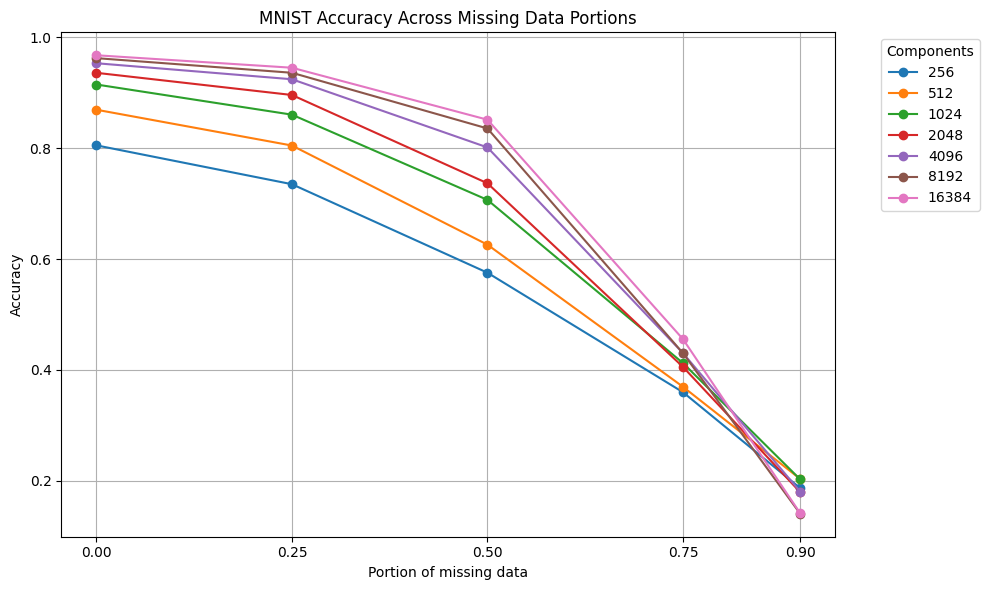

In [44]:
perf_matrix = np.array([acc_dict[m] for m in missing_rates]).T

plt.figure(figsize=(10, 6))
for idx, temp in enumerate(n_bins_list):
    plt.plot(missing_rates, perf_matrix[idx], marker='o', label=str(temp))
plt.xlabel("Portion of missing data")
plt.ylabel("Accuracy")
plt.xticks(missing_rates)
plt.grid(True)
plt.legend(title="Components", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.title("MNIST Accuracy Across Missing Data Portions")
plt.tight_layout()
# plt.show()
plt.savefig('../../lam0.2_acc.pdf')


# Temporary laziness

In [ ]:
for lamda in [0.6, 0.8, 1]:
    # model hyperparams
    dataset = 'mnist' if use_mnist else 'bmnist'
    latent_dim = 16
    num_bins_trained = 16_384
    version_num = 0

    # load model
    model_path = glob.glob(repo_dir+f'/logs/{dataset}/hybrid/latent_dim_{latent_dim}/num_bins_{num_bins_trained}/lambda_{lamda:.2f}/version_{version_num}/checkpoints/*.ckpt')[0]
    model = ContinuousMixture.load_from_checkpoint(model_path).to(device)
    model.n_chunks = 32
    model.missing = False # this was True before, check if difference (hope not)
    model.eval(); # semi-colon to prevent printing model architecture
    print(model_path)

    missing_rates = [0.00]#, 0.25, 0.50, 0.75, 0.90]
    acc_dict = {k: [] for k in missing_rates}
    test_lls = []

    for missing_rate in missing_rates:
        n_bins_list, acc_list, test_lls_list = compute_accuracies(
            model=model,
            X_test=X_test,
            y_test=y_test,
            lower_power_bound=8,
            upper_power_bound=15,
            latent_opt=False,
            use_mnist=use_mnist,
            missing_rate=missing_rate,
        )
        if missing_rate == 0.0:
            test_lls = test_lls_list
        acc_dict[missing_rate] = acc_list

    print(f"latent_dim_{latent_dim}/n_bins_{num_bins_trained}/epoch_{int(model_path.split('epoch=')[-1].split('.', 1)[0])} - LAMBDA {lamda:.2f}")
    for i in range(len(n_bins_list)):
        n_bins = n_bins_list[i]
        str_to_print = f"Mean LL and Accuracy for {n_bins:5d} bins: {test_lls[i]:.4f}"
        for missing_rate in missing_rates:
            str_to_print += f" : {acc_dict[missing_rate][i]:.4f}"
        print(str_to_print)

## Evaluate sample quality

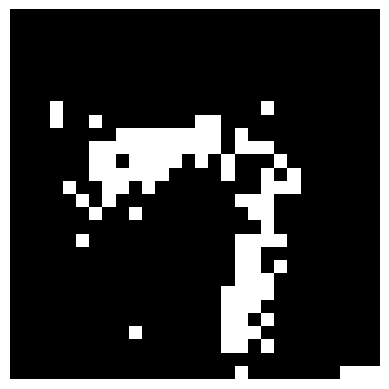

In [58]:
def reconstruct_image(grayscale_vector):
    image_data = grayscale_vector.reshape((28, 28))
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')
    # plt.show()
    plt.savefig("../../lam0.2_sample_4.pdf")

from random import randint

decoder_arch = 'MLP'
n_bins = 32
model.sampler.n_bins = n_bins
z, log_w = model.sampler(seed=42)
logits_tensor = model.decoder.net(z.to(device))
logits_sample = logits_tensor[randint(0, n_bins - 1)]

if decoder_arch == 'tConv':
    logits_permute = logits_sample.permute(1, 2, 0)
    logits_flat = logits_permute.reshape(-1, logits_permute.shape[-1])
    sampled_pixel_vals = torch.distributions.Categorical(logits=logits_flat).sample()
    reconstruct_image(sampled_pixel_vals.view(28, 28).detach().cpu())
else:
    probs = torch.sigmoid(logits_sample)
    sample = torch.bernoulli(probs)
    reconstruct_image(sample.detach().cpu())

# Load training and validation (for latent opt.)

In [ ]:
# download MNIST into data directory (if needed)
mnist_train_and_val = datasets.MNIST(root="../data", train=True, download=True)

# assign labels
labels_mnist_train_and_val = mnist_train_and_val.targets

# convert datasets to tensors
mnist_train_and_val = mnist_train_and_val.data.view(60_000, 784).float()

# embed class label in final pixel(s) of training samples
for idx in range(mnist_train_and_val.shape[0]):
    label = labels_mnist_train_and_val[idx]
    if use_mnist:
        mnist_train_and_val[idx][-1] = label
        # bin_label = torch.tensor([int(d) for d in bin(label)[2:].zfill(4)]).float()
        # mnist_train_and_val[idx][-4:] = bin_label
    else:
        binary_label = 255 * torch.tensor([int(d) for d in bin(label)[2:].zfill(4)]).float()
        mnist_train_and_val[idx][-4:] = binary_label

# define train and validation
if use_mnist:
    X_train = mnist_train_and_val[0:50_000]
    X_val   = mnist_train_and_val[50_000::]
else: # if use_mnist is False then binarise
    X_train = (mnist_train_and_val[0:50_000] / 255 >= 0.5).float()
    X_val   = (mnist_train_and_val[50_000::] / 255 >= 0.5).float()

y_train = labels_mnist_train_and_val[0:50_000]
y_val   = labels_mnist_train_and_val[50_000::]

# load data into data loaders
batch_size = 128
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(X_val  , batch_size=batch_size)

# Latent optimisation: test on full data

In [ ]:
print(model_path)
# latent optimisation should really be done here to avoid doing it again for missing
bins_full, acc_full, z_opt = compute_accuracies(
    model=model,
    X_test=X_test,
    y_test=y_test,
    lower_power_bound=8,
    upper_power_bound=9,
    latent_opt=True,
    use_mnist=use_mnist,
    missing=False
)

## Evaluate sample quality

In [ ]:
def reconstruct_image(grayscale_vector):
    image_data = grayscale_vector.reshape((28, 28))
    plt.imshow(image_data, cmap='gray')
    plt.axis('off')
    plt.show()

from random import randint

decoder_arch = 'MLP'
n_bins = 32
model.sampler.n_bins = n_bins
z, log_w = model.sampler(seed=42)
logits_tensor = model.decoder.net(z.to(device))
logits_sample = logits_tensor[randint(0, n_bins - 1)]

if decoder_arch == 'tConv':
    logits_permute = logits_sample.permute(1, 2, 0)
    logits_flat = logits_permute.reshape(-1, logits_permute.shape[-1])
    sampled_pixel_vals = torch.distributions.Categorical(logits=logits_flat).sample()
    reconstruct_image(sampled_pixel_vals.view(28, 28).detach().cpu())
else:
    probs = torch.sigmoid(logits_sample)
    sample = torch.bernoulli(probs)
    reconstruct_image(sample.detach().cpu())